<a href="https://colab.research.google.com/github/yy0750/Unsold_Apartments_Spatial_Analysis/blob/main/%EB%AF%B8%EB%B6%84%EC%96%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # 한글
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/spatio-temporal/경쟁률.csv')
seoul_shp = gpd.read_file('/content/drive/MyDrive/spatio-temporal/LARD_ADM_SECT_SGG_11.shp')
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.경도, data.위도))

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from sklearn.preprocessing import StandardScaler
import io
import geopandas as gpd
import seaborn as sns

plt.rc('font', family='NanumBarunGothic') #폰트를 나눔 고딕 폰트로 지정

In [ ]:
# CSV 파일 로드 (
df_competition = pd.read_csv('/content/drive/MyDrive/spatio-temporal/경쟁률.csv')
df_unsold = pd.read_csv('/content/drive/MyDrive/spatio-temporal/미분양.csv')
df_population_gdp = pd.read_csv('/content/drive/MyDrive/spatio-temporal/인구수총생산.csv')

# 데이터 전처리 및 병합 키 생성
df_competition['연도'] = df_competition['연도'].astype(str)
df_unsold['연도'] = pd.to_datetime(df_unsold['연도']).dt.year.astype(str)
df_competition['merge_key'] = df_competition['연도'] + df_competition['지역']
df_unsold['merge_key'] = df_unsold['연도'] + df_unsold['지역']

# df_competition과 df_unsold 데이터프레임 병합
merged_data = pd.merge(df_competition, df_unsold, on='merge_key', how='inner', suffixes=('_comp', '_unsold'))

# 병합된 데이터프레임과 df_population_gdp 병합
# df_population_gdp에는 연도 정보가 없으므로 '지역' 컬럼을 직접 지정하여 병합
merged_final_data = pd.merge(merged_data, df_population_gdp, left_on='지역_comp', right_on='지역', how='left')

merged_final_data.head()

In [ ]:
# 상관관계 분석
relevant_columns = ['경쟁률', '데이터', '인구', '면적', '인구밀도', '지역내총생산']
correlation_data = merged_final_data[relevant_columns].dropna()
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Variable Correlation Matrix')
plt.show()

In [ ]:
# Folium 지도 초기화
map_all_locations = folium.Map(location=[map_center_latitude, map_center_longitude], zoom_start=11)

# 모든 좌표에 대해 마커 추가
for idx, row in merged_final_data.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        color='red',  # 모든 좌표를 동일한 색상으로 표시
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=(f"지역: {row['지역_comp']}")
    ).add_to(map_all_locations)

# 지도 저장 (옵션)
map_all_locations.save('all_locations.html')

# 지도 표시
map_all_locations


In [ ]:
# Elbow Method
scaler = StandardScaler()
scaled_data = scaler.fit_transform(correlation_data)

inertia = []
K_range = range(1, 11)
for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(scaled_data)
    inertia.append(model.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.show()



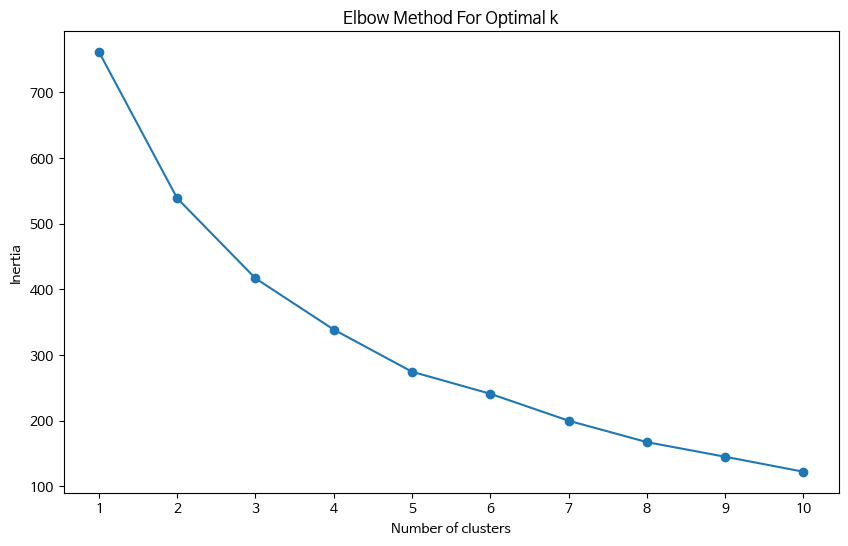

In [ ]:
# KMeans 클러스터링
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

merged_final_data['Cluster'] = clusters

# Folium 지도 시각화
map_center_latitude = merged_final_data['위도'].mean()
map_center_longitude = merged_final_data['경도'].mean()
map_seoul = folium.Map(location=[map_center_latitude, map_center_longitude], zoom_start=11)

cluster_colors = ['blue', 'green', 'red', 'purple']

for idx, row in merged_final_data.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        color=cluster_colors[row['Cluster']],
        fill=True,
        fill_color=cluster_colors[row['Cluster']],
        fill_opacity=0.7,
        popup=(f"지역: {row['지역_comp']}, 경쟁률: {row['경쟁률']}")
    ).add_to(map_seoul)

map_seoul.save('seoul_unsold_apartments.html')

map_seoul